# Align prediction mask to ground truth mask/image

Post-process MedSAM2 segmentation prediction results to align them with the ground truth image so they can be visualized in Slicer3D and Niivue.
Origin isn't getting saved from MedSAM2 prediction.

In [1]:
%cd ../..

/Users/katyscott/Documents/BHKLab_GitHub/ocscc_tumor_characterization


In [2]:
import SimpleITK as sitk
from damply import dirs
from pathlib import Path
import pandas as pd
import csv

from readii_2_roqc.utils.metadata import insert_SampleID
from readii.image_processing import displayCTSegOverlay, alignImages

/Users/katyscott/Documents/BHKLab_GitHub/ocscc_tumor_characterization/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = "RADCURE_OCSCC"
images_dir = dirs.PROCDATA / dataset / "images"

gt_dir = Path(f"mit_{dataset}")
pred_dir = Path(f"medsam_{dataset}/masks")

2025-11-10 | WARNING | Environment variable 'PROCDATA' is not set. Using default path relative to project root.


## Make list of patient IDs from directory of predicted masks
Use this to subset the full MIT RADCURE outputs

In [4]:
pat_list = sorted([file.name.removesuffix(".nii.gz") for file in (images_dir / pred_dir).iterdir()])

with (dirs.PROCDATA / dataset / "metadata" / "patient_list.csv").open("w") as f:
    writer = csv.writer(f)
    for pat in pat_list:
        writer.writerow([pat])

In [15]:
mit_list = sorted([dir.name for dir in (images_dir / gt_dir).glob("*/")])

Subset the MIT autopipeline index

In [5]:
# Path to raw MIT RADCURE index files
raw_mit_path = dirs.RAWDATA / "RADCURE_GTVp" / "images" / "mit_RADCURE_GTVp"
simple_index = pd.read_csv(raw_mit_path / "mit_RADCURE_GTVp_index-simple.csv")
complete_index = pd.read_csv(raw_mit_path / "mit_RADCURE_GTVp_index.csv")

# Generate SampleID column and set as index
simple_index = insert_SampleID(simple_index)
complete_index = insert_SampleID(complete_index)

simple_index.set_index('SampleID', inplace=True)
complete_index.set_index('SampleID', inplace=True)

# Select rows corresponding to patients with MedSAM2 predictions
ocscc_simple = simple_index.loc[pat_list]
ocscc_complete = complete_index.loc[pat_list]

# Save subsetted index files
ocscc_simple.to_csv(images_dir / gt_dir / "mit_RADCURE_OCSCC_index-simple.csv")
ocscc_complete.to_csv(images_dir / gt_dir / "mit_RADCURE_OCSCC_index.csv")

2025-11-10 | WARNING | Environment variable 'RAWDATA' is not set. Using default path relative to project root.


## Load image data to check alignment

In [17]:
# patient_id = "RADCURE-0014_0008"

for patient_id in pat_list:

    image_file = ocscc_simple[(ocscc_simple.index == patient_id) & (ocscc_simple['Modality'] == 'CT')]['filepath'].values[0]
    gt_mask_file = ocscc_simple[(ocscc_simple.index == patient_id) & (ocscc_simple['Modality'] == 'RTSTRUCT')]['filepath'].values[0]

    pred_mask_file = f"{patient_id}.nii.gz"

    image = sitk.ReadImage(images_dir / gt_dir / image_file)
    # gt_mask = sitk.ReadImage(images_dir / gt_dir / gt_mask_file)
    pred_mask = sitk.ReadImage(images_dir / pred_dir / pred_mask_file)

    aligned_pred_mask = alignImages(image, pred_mask)

    aligned_img_dir = images_dir / pred_dir.parent / "aligned_masks"
    aligned_img_dir.mkdir(parents=True, exist_ok=True)

    sitk.WriteImage(aligned_pred_mask, aligned_img_dir / pred_mask_file)

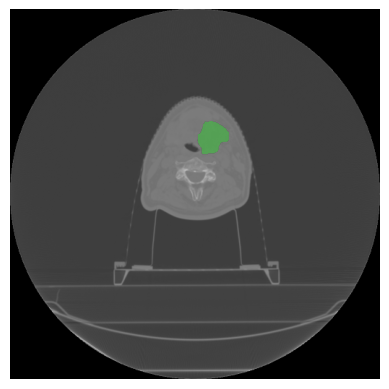

In [8]:
displayCTSegOverlay(image, aligned_pred_mask, sliceIdx=100)